In [274]:
## HELPER FUNCTIONS AND MODULES
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
%matplotlib inline

def sigmoid( z ):
    """ This shrinks our beta estimate into logistic form """
    return 1 / ( 1 + np.exp( -z ) )

def cost_ll( X, y, betas ):
    """ """
    # this is the current estimate
    p = sigmoid( np.dot( betas, X.T ) )
    # this measures the difference between the guess and the actual
    return -np.sum( y*np.log( p+1e-8 ) + (1-y)*np.log( 1 - p+1e-8  ) ) 

def gradient( X, y, betas ):
    """ This calculates the gradient given X, y and our betas """
    # when stochastic gradient descent is computed over a 
    # vector of X and a vector of betas with the y response
    #  - need a part to check for a vector
    return np.dot( ( y - sigmoid( np.dot( X, betas ) ) ), X )

def approx_hes( X, y, betas ):
    """
    Newtons method creates a weight matrix based on the 2nd derivative of each beta 
    """
    # needed to initialize a matrix approximating the hessian
    N, P = X.shape

    # logistic estimate
    z    = sigmoid( np.dot( X, betas ) ) 

    # function as weight or coefficents on X
    W    = np.multiply( z, ( 1.0-z ) ) 

    # coefficients for our approximate hessian 
    ap_H = np.zeros( (P, P) )

    # cycles through each observation (N) adding the outer product of the X values
    # and multiply that by the W vector used in the regular hessian calculations. 
    for obv in np.arange( N ):
        ap_H += np.multiply( W[obv], np.outer( X[obv], X[obv] ) )
    return ap_H

def cost_ll( X, y, betas ):
    """ """
    # this is the current estimate
    p = sigmoid( np.dot( betas, X.T ) )
    # this measures the difference between the guess and the actual
    return -np.sum( y*np.log( p+1e-8 ) + (1-y)*np.log( 1 - p+1e-8 ) ) 


# Line Search

### Choosing the best line length

- We can instead decide how large of a step we take during stochastic gradient descent.

- Below is a line search that uses the wolfe conditionts to compute an alpha.

- In order to do this we need a few functions. See Nocedal & Wright for details (expand to specific areas to reference) - much of the notation used in the code follows notation used in Nocedal & Wright.


In [260]:
def ls( betas, p, f, gf, c=1e-8, iterations=100, s=0.75):
    '''
     This function uses the wolf conditions to compute the "optimal" stepsize for 
     the next step in a descent method.

    '''
    N, P = X.shape
    
    # the loss function
    fx = f( betas )
    
    # the gradient function multipled by the direction vector
    gfp = gf( betas ).dot( p )
    
    # initialized alpha
    a = 1.
    
    # because it's not working...
#     print( "p =", p )
#     print( "fx =", fx )
#     print( "gfp =", gfp ) 
    
    # a boolean for knowing if we've found one - we haven't yet. 
    eee = False
    
    # what's the best length given p one? 
    for iters in np.arange( iterations ):
        
        # calculate the potential
        fxap = f( betas + a * p )
#         print( "a =", a )
#         print( "fxap =", fxap )
#         print( "fx + c * a * gfp =", fx + c * a * gfp )

        # if the potential leads to smaller cost, then go for it. 
        if fxap <= fx + c * a * gfp:
            eee = True
            return eee, a
        
        # if not, then scale alpha down (by s) and retry!
        else:
            a*=s
    
    print("seems like there is no better alpha...")        
    return eee, a

In [273]:
def logit_gd( X, y, iterations=1000, alpha=0.01, tol=1e-8):
    """ This function performs 'simple' gradient descent.
        - X is the data matrix - X is scaled before performing descent
        - y are the actual values 
        - beta vector is initialized at a vector of zeros 
        - alpha or the learning rate is by default 0.00001 """
 
    # initialize betas vector
    betas = np.zeros( X.shape[1] )
    
    # initialize empty convergence vector and empty convergence difference vector
    cvg = []
    betas_hist = []
    steps = []
    for iters in np.arange( iterations ):
        
        # get initial cost
        if iters == 0:
            cvg.append( cost_ll( X, y, betas ) )
            betas_hist.append( betas )
            
        # ammend to adjust alpha based on iteration step
        betas += alpha * gradient( X, y, betas )
        betas_hist.append( betas )
        
        # save log likelihood output for plotting
        cvg.append( cost_ll( X, y, betas ) )
        steps.append( alpha )
        
        # check for convergence 
        if np.abs( cvg[-1] - cvg[-2] ) > tol:
            pass            
        else:
            # we made it! how many iterations?
            print("iterations to converge, %d "%iters )
            return betas, betas_hist, cvg, steps
        
    print("Did not converge, lower tolerance?")
    return betas, betas_hist, cvg, steps

In [295]:
def lsgd( X, y, tol=1e-4, iterations=1000, c_up=0.5, s_up=0.75 ):
    '''
    This function performs a line search gradient descent method to find the beta
    that minimizes the negative log likelihood function.
    
    Inputs:
    X: an m by n array of features
    y: an m vector of successes
    beta: an initial guess for the minimizer (for which we are solving)
    m: an m vector of the number of trials
    tol: a float, optional to specify the error size used to indicate convergence
    iters; an integer, optional to specify the max number of iterations for the
         algorithm
    cval: A float, option to specify the constant value used to determine stepsize
        in linesearch
    print_total: A boolean to determine whether the number of iterations it takes 
        to converge should be printed or not.
         
    Returns:
    beta0: the minimizer of the negative log-likelihood
    betas: a list of the new beta for each time step
    ll: a list of the log likelihoods for each time step
    '''
    N, P = X.shape
    
    # initialize betas vector
    betas0 = np.zeros( P )
    
    def f(betas):
        # formats function for ls function
        return cost_ll(X, y, betas )
    
    def gf(betas):
        # formats function for ls function
        return gradient(X, y, betas )
    
    # keep track of some things.
    cvg = [] 
    steps = []
    betas_hist = []
    for iters in np.arange( iterations ):
        # before
        cost_ll_betas0 = cost_ll( X, y, betas0 )
        cvg.append( cost_ll_betas0 )
        betas_hist.append(betas0)

        # first get the descent direction
        p  = -gradient( X, y, betas0 ) 
        eee, alpha = ls( betas0, p, f, gf, c=c_up, iterations=1000, s=s_up )
        
        # collect the step sizes
        if eee is not True:
            steps.append( alpha )
            print( "stepsize no bueno, no lines" )
            return betas, betas_hist, cvg, steps
        
        # if we found a good line then lets use it! (save alpha)
        steps.append( alpha )
        betas1 = betas0 + alpha * p
        
        # after
        cost_ll_betas1 = cost_ll( X, y, betas1 )
        cvg.append( cost_ll_betas0 )
        
        # checks for convergence
        if np.abs( cost_ll_betas1 - cost_ll_betas0 ) > tol:
            beta0 = beta1
        else:
            # we made it! how many iterations?
            print("iterations to converge, %d "%iters )
            return betas1, betas_hist, cvg, steps
        
    return betas1, betas_hist, cvg, steps

In [246]:
# TEST IT OUT ON SOME RANDOM DATA!
N = 400
P = 8

# Pre-process, add intercept
X = np.hstack( (np.ones( (N,1) ), np.random.rand( N, P) ) )
y = (np.random.rand( N ) > .5).astype(float)

print( X.shape )

In [296]:
# lgsd code not working

betas, betas_hist, cvg, steps     = lsgd( X, y, tol=1e-8, iterations=1000, c_up=.5, s_up=.75 )
betas1, betas_hist1, cvg1, steps1 = logit_gd( X, y, iterations=50000, alpha=0.001, tol=1e-3)


iterations to converge, 0 
iterations to converge, 290 


In [297]:
# comparing the difference in estimates between the two...
y1 = X.dot( betas.T )
y2 = X.dot( betas1.T )
print( la.norm(y1 - y) )
print( la.norm(y2 - y) )
print( la.norm(betas - betas1) )


14.212670403551897
14.490204362369457
0.9572060029314421


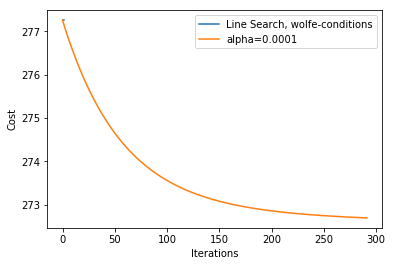

In [299]:
# plot the convergence paths
plt.plot(cvg, label="Line Search, wolfe-conditions")
plt.plot(cvg1, label="alpha=0.0001")
plt.legend(loc="best")
plt.xlabel('Iterations')
plt.ylabel('Cost')


### Something is not happening correctly in my line search algorithm...

The line search algorithm 

In [300]:
# Comparing convergence for various values of C
# strightforward if line search alogrithm is working...




### Quasi Newton Methods